In [24]:
# Let's check the environment and DSSP installation
import sys
import subprocess
import os

print("Environment Information:")
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
print(f"Working directory: {os.getcwd()}")

# Check DSSP
print("\nDSSP Check:")
try:
    result = subprocess.run(['mkdssp', '--version'], capture_output=True, text=True)
    print(f"DSSP version: {result.stdout.strip()}")
    print(f"DSSP path: {subprocess.run(['which', 'mkdssp'], capture_output=True, text=True).stdout.strip()}")
except Exception as e:
    print(f"DSSP not found: {e}")

# Check environment variables
print(f"\nLIBCIFPP_DATA_DIR: {os.environ.get('LIBCIFPP_DATA_DIR', 'Not set')}")

# Try a simple DSSP test
print("\nTesting DSSP directly on command line:")
test_pdb = "../datasets/all_pdbs/1a00.pdb"
try:
    result = subprocess.run(['mkdssp', test_pdb, '/tmp/notebook_dssp_test.out'], 
                           capture_output=True, text=True)
    print(f"Return code: {result.returncode}")
    if result.stdout:
        print(f"STDOUT: {result.stdout[:200]}...")
    if result.stderr:
        print(f"STDERR: {result.stderr[:200]}...")
    
    # Check if output was created
    if os.path.exists('/tmp/notebook_dssp_test.out'):
        size = os.path.getsize('/tmp/notebook_dssp_test.out')
        print(f"Output file created: {size} bytes")
    else:
        print("No output file created")
        
except Exception as e:
    print(f"Command line DSSP failed: {e}")

Environment Information:
Python executable: /home/t-alptartici/miniconda3/envs/dssp_env/bin/python
Python version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 17:57:12) 
[GCC 13.3.0]
Working directory: /home/t-alptartici/inverse-folding/notebooks

DSSP Check:
DSSP version: mkdssp version 4.4.11
DSSP path: /home/t-alptartici/miniconda3/envs/dssp_env/bin/mkdssp

LIBCIFPP_DATA_DIR: /home/t-alptartici/miniconda3/envs/dssp_env/share/libcifpp

Testing DSSP directly on command line:
Return code: 1
STDERR: Error while loading dictionary mmcif_pdbx.dic
 >> basic_filebuf::underflow error reading the file: Is a directory
...
No output file created


In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# BioPython imports
from Bio import PDB
from Bio.PDB import DSSP, MMCIFParser, PDBParser
from Bio.PDB.Structure import Structure
from Bio.PDB.Chain import Chain
from Bio.PDB.Residue import Residue

print("Imports successful!")
print("Available DSSP secondary structure codes:")
print("H: α-helix")
print("B: β-bridge") 
print("E: β-strand")
print("G: 3₁₀-helix")
print("I: π-helix")
print("T: turn")
print("S: bend")
print("-: coil/loop")

Imports successful!
Available DSSP secondary structure codes:
H: α-helix
B: β-bridge
E: β-strand
G: 3₁₀-helix
I: π-helix
T: turn
S: bend
-: coil/loop


In [2]:
def parse_structure_file(file_path: str) -> Structure:
    """
    Parse a PDB or mmCIF file and return a BioPython Structure object.
    
    Args:
        file_path (str): Path to the PDB or mmCIF file
        
    Returns:
        Structure: BioPython Structure object
        
    Raises:
        ValueError: If file format is not supported
        FileNotFoundError: If file doesn't exist
    """
    file_path = Path(file_path)
    
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")
    
    file_ext = file_path.suffix.lower()
    structure_id = file_path.stem
    
    if file_ext == '.pdb':
        parser = PDBParser(QUIET=True)
    elif file_ext in ['.cif', '.mmcif']:
        parser = MMCIFParser(QUIET=True)
    else:
        raise ValueError(f"Unsupported file format: {file_ext}. Supported formats: .pdb, .cif, .mmcif")
    
    structure = parser.get_structure(structure_id, str(file_path))
    print(f"Successfully parsed {file_path} with {len(list(structure.get_chains()))} chains")
    
    return structure

In [3]:
def compute_dssp_per_residue(structure: Structure, 
                           chain_id: Optional[str] = None) -> Dict[str, List[Dict]]:
    """
    Compute DSSP secondary structure assignment per residue for a structure.
    
    Args:
        structure (Structure): BioPython Structure object
        chain_id (str, optional): Specific chain ID to process. If None, process all chains.
        
    Returns:
        Dict[str, List[Dict]]: Dictionary with chain IDs as keys and lists of residue info as values
                              Each residue dict contains: residue_id, residue_name, secondary_structure, 
                              accessibility, phi, psi
    """
    results = {}
    
    # Get the first model (assuming single model structure)
    model = structure[0]
    
    # Filter chains if specific chain_id provided
    chains_to_process = [model[chain_id]] if chain_id else model.get_chains()
    
    for chain in chains_to_process:
        chain_id = chain.get_id()
        print(f"Processing chain {chain_id}...")
        
        try:
            # Compute DSSP
            dssp = DSSP(model, structure.get_id() + ".pdb", dssp='mkdssp')
            
            chain_results = []
            
            # Iterate through residues in the chain
            for residue in chain.get_residues():
                # Skip heteroatoms and water molecules
                if residue.get_id()[0] != ' ':
                    continue
                    
                residue_id = residue.get_id()[1]  # residue number
                residue_name = residue.get_resname()
                
                # Get DSSP data for this residue
                dssp_key = (chain_id, residue.get_id())
                
                if dssp_key in dssp:
                    dssp_data = dssp[dssp_key]
                    secondary_structure = dssp_data[2]  # Secondary structure
                    accessibility = dssp_data[3]       # Relative accessibility
                    phi = dssp_data[4]                 # Phi angle
                    psi = dssp_data[5]                 # Psi angle
                else:
                    # If DSSP couldn't compute for this residue
                    secondary_structure = '-'
                    accessibility = 0.0
                    phi = 360.0  # DSSP uses 360.0 for undefined angles
                    psi = 360.0
                
                residue_info = {
                    'residue_id': residue_id,
                    'residue_name': residue_name,
                    'secondary_structure': secondary_structure,
                    'accessibility': accessibility,
                    'phi': phi,
                    'psi': psi
                }
                
                chain_results.append(residue_info)
            
            results[chain_id] = chain_results
            print(f"Chain {chain_id}: {len(chain_results)} residues processed")
            
        except Exception as e:
            print(f"Error processing chain {chain_id}: {str(e)}")
            results[chain_id] = []
    
    return results

In [4]:
def dssp_from_file(file_path: str, 
                   chain_id: Optional[str] = None, 
                   output_format: str = 'dict') -> Union[Dict, pd.DataFrame]:
    """
    Main function to compute DSSP from a PDB or mmCIF file.
    
    Args:
        file_path (str): Path to the PDB or mmCIF file
        chain_id (str, optional): Specific chain ID to process. If None, process all chains.
        output_format (str): Output format - 'dict' or 'dataframe'
        
    Returns:
        Union[Dict, pd.DataFrame]: DSSP results in specified format
    """
    # Parse the structure file
    structure = parse_structure_file(file_path)
    
    # Compute DSSP
    dssp_results = compute_dssp_per_residue(structure, chain_id)
    
    if output_format == 'dataframe':
        # Convert to DataFrame
        all_residues = []
        for chain_id, residues in dssp_results.items():
            for residue in residues:
                residue['chain_id'] = chain_id
                all_residues.append(residue)
        
        df = pd.DataFrame(all_residues)
        # Reorder columns for better readability
        if not df.empty:
            col_order = ['chain_id', 'residue_id', 'residue_name', 'secondary_structure', 
                        'accessibility', 'phi', 'psi']
            df = df[col_order]
        return df
    
    return dssp_results

def summarize_secondary_structure(dssp_results: Union[Dict, pd.DataFrame]) -> Dict:
    """
    Summarize secondary structure content.
    
    Args:
        dssp_results: DSSP results from dssp_from_file function
        
    Returns:
        Dict: Summary statistics of secondary structure content
    """
    if isinstance(dssp_results, pd.DataFrame):
        ss_counts = dssp_results['secondary_structure'].value_counts()
    else:
        # Dictionary format
        all_ss = []
        for chain_residues in dssp_results.values():
            for residue in chain_residues:
                all_ss.append(residue['secondary_structure'])
        ss_counts = pd.Series(all_ss).value_counts()
    
    total_residues = ss_counts.sum()
    
    summary = {}
    ss_names = {
        'H': 'α-helix',
        'B': 'β-bridge', 
        'E': 'β-strand',
        'G': '3₁₀-helix',
        'I': 'π-helix',
        'T': 'turn',
        'S': 'bend',
        '-': 'coil/loop'
    }
    
    for ss_code, count in ss_counts.items():
        percentage = (count / total_residues) * 100
        ss_name = ss_names.get(ss_code, f'Unknown ({ss_code})')
        summary[ss_name] = {
            'count': count,
            'percentage': round(percentage, 2)
        }
    
    summary['total_residues'] = total_residues
    return summary

## Example Usage

Below are examples of how to use the DSSP computation functions with PDB and mmCIF files.

### Basic Usage:
1. **Parse and compute DSSP for all chains**: `dssp_from_file("protein.pdb")`
2. **Process specific chain**: `dssp_from_file("protein.pdb", chain_id="A")`  
3. **Get results as DataFrame**: `dssp_from_file("protein.pdb", output_format="dataframe")`
4. **Summarize secondary structure**: `summarize_secondary_structure(results)`

In [ ]:
## DSSP Environment Setup

To create a complete environment for DSSP computation, you'll need the following packages and tools:

### Core Requirements:

#### 1. **DSSP Software** (Essential)
- **Package**: `dssp` or `mkdssp`
- **Installation**: 
  - Via conda: `conda install -c bioconda dssp`
  - Via apt (Ubuntu/Debian): `sudo apt-get install dssp`
  - Via brew (macOS): `brew install brewsci/bio/dssp`
  - From source: https://github.com/PDB-REDO/dssp

#### 2. **Python Packages**:

**Core BioPython stack:**
- `biopython>=1.80` - For PDB/mmCIF parsing and DSSP interface
- `numpy>=1.20.0` - Numerical computing
- `pandas>=1.3.0` - Data manipulation and analysis

**Optional but recommended:**
- `requests>=2.25.0` - For downloading PDB files from RCSB
- `matplotlib>=3.5.0` - For plotting secondary structure content
- `seaborn>=0.11.0` - Enhanced plotting capabilities
- `jupyter` - For notebook environment
- `ipykernel` - Jupyter kernel support

### Environment Creation Commands:

#### Option 1: Conda Environment (Recommended)
```bash
# Create new environment
conda create -n dssp_env python=3.9

# Activate environment
conda activate dssp_env

# Install packages
conda install -c bioconda dssp
conda install -c conda-forge biopython numpy pandas requests matplotlib seaborn jupyter
```

#### Option 2: Pip + System DSSP
```bash
# Create virtual environment
python -m venv dssp_env
source dssp_env/bin/activate  # Linux/Mac
# or dssp_env\Scripts\activate  # Windows

# Install Python packages
pip install biopython numpy pandas requests matplotlib seaborn jupyter

# Install DSSP separately via system package manager
```

#### Option 3: Complete requirements.txt
```text
biopython>=1.80
numpy>=1.20.0
pandas>=1.3.0
requests>=2.25.0
matplotlib>=3.5.0
seaborn>=0.11.0
jupyter>=1.0.0
ipykernel>=6.0.0
```

### Verification:
After installation, verify everything works:
- `which dssp` or `which mkdssp` should return a path
- `python -c "from Bio.PDB import DSSP; print('DSSP import successful')"`

In [1]:
# Practical DSSP Environment Setup and Verification

import subprocess
import sys
import shutil
from pathlib import Path

def check_dssp_availability():
    """Check if DSSP is available and provide installation guidance."""
    dssp_commands = ['dssp', 'mkdssp']
    found_dssp = None
    
    print("=== DSSP Availability Check ===")
    for cmd in dssp_commands:
        path = shutil.which(cmd)
        if path:
            print(f"✅ {cmd} found at: {path}")
            found_dssp = cmd
        else:
            print(f"❌ {cmd} not found")
    
    return found_dssp

def check_python_packages():
    """Check if required Python packages are installed."""
    required_packages = {
        'Bio': 'biopython',
        'numpy': 'numpy', 
        'pandas': 'pandas',
        'requests': 'requests',
        'matplotlib': 'matplotlib'
    }
    
    print("\n=== Python Package Check ===")
    missing_packages = []
    
    for import_name, package_name in required_packages.items():
        try:
            __import__(import_name)
            print(f"✅ {package_name} - Available")
        except ImportError:
            print(f"❌ {package_name} - Missing")
            missing_packages.append(package_name)
    
    return missing_packages

def install_dssp_conda():
    """Install DSSP via conda."""
    print("\n=== Installing DSSP via Conda ===")
    try:
        result = subprocess.run([
            'conda', 'install', '-c', 'bioconda', 'dssp', '-y'
        ], capture_output=True, text=True, timeout=300)
        
        if result.returncode == 0:
            print("✅ DSSP installed successfully!")
            return True
        else:
            print(f"❌ Installation failed: {result.stderr}")
            return False
    except Exception as e:
        print(f"❌ Error during installation: {e}")
        return False

def create_environment_yaml():
    """Create a complete environment.yml file for DSSP work."""
    env_content = """name: dssp_env
channels:
  - bioconda
  - conda-forge
  - defaults
dependencies:
  - python=3.9
  - dssp
  - biopython>=1.80
  - numpy>=1.20.0
  - pandas>=1.3.0
  - requests>=2.25.0
  - matplotlib>=3.5.0
  - seaborn>=0.11.0
  - jupyter
  - ipykernel
  - pip
  - pip:
    - any-additional-pip-packages
"""
    
    with open('dssp_environment.yml', 'w') as f:
        f.write(env_content)
    
    print("✅ Created dssp_environment.yml")
    print("To create the environment, run:")
    print("  conda env create -f dssp_environment.yml")
    print("  conda activate dssp_env")

# Run the checks
dssp_cmd = check_dssp_availability()
missing_packages = check_python_packages()

if missing_packages:
    print(f"\n⚠️  Missing packages: {', '.join(missing_packages)}")
    print("Install with: pip install " + " ".join(missing_packages))

if not dssp_cmd:
    print("\n⚠️  DSSP not found. Installation options:")
    print("1. Conda: conda install -c bioconda dssp")
    print("2. Ubuntu/Debian: sudo apt-get install dssp") 
    print("3. macOS: brew install brewsci/bio/dssp")

# Create environment file for future use
create_environment_yaml()

=== DSSP Availability Check ===
❌ dssp not found
✅ mkdssp found at: /home/t-alptartici/miniconda3/envs/dssp_env/bin/mkdssp

=== Python Package Check ===
✅ biopython - Available
✅ numpy - Available
✅ pandas - Available
✅ requests - Available
✅ matplotlib - Available
✅ Created dssp_environment.yml
To create the environment, run:
  conda env create -f dssp_environment.yml
  conda activate dssp_env


## Summary: Complete DSSP Environment Requirements

Based on the analysis above, here's everything you need for DSSP computation:

### 🔧 **Essential Components:**

1. **DSSP Binary** (Critical - this is missing!)
   - `dssp` or `mkdssp` executable
   - Install via: `conda install -c bioconda dssp`

2. **Python Packages** (✅ Already available):
   - `biopython>=1.80` - PDB/mmCIF parsing and DSSP interface
   - `numpy>=1.20.0` - Numerical operations
   - `pandas>=1.3.0` - Data handling
   - `requests>=2.25.0` - File downloading
   - `matplotlib>=3.5.0` - Plotting

### 📦 **Quick Setup Commands:**

**Option 1: Install DSSP in current environment**
```bash
conda install -c bioconda dssp
```

**Option 2: Create dedicated environment**
```bash
conda env create -f dssp_environment.yml
conda activate dssp_env
```

**Option 3: One-liner for new environment**
```bash
conda create -n dssp_env -c bioconda -c conda-forge python=3.9 dssp biopython numpy pandas requests matplotlib seaborn jupyter
```

### 🔍 **Additional Useful Packages:**
- `seaborn>=0.11.0` - Enhanced plotting
- `plotly>=5.0.0` - Interactive plots  
- `biotite>=0.34.0` - Alternative structure analysis
- `py3Dmol>=2.0.0` - 3D structure visualization
- `mdtraj>=1.9.0` - Trajectory analysis (if working with MD data)

The environment file `dssp_environment.yml` has been created for you!

In [6]:
# Example: Download a test PDB file if needed
import requests

def download_test_pdb(pdb_id: str = "1ubq", save_path: str = "test_protein.pdb"):
    """Download a test PDB file from RCSB PDB."""
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        with open(save_path, 'w') as f:
            f.write(response.text)
        
        print(f"Downloaded {pdb_id} to {save_path}")
        return save_path
    except Exception as e:
        print(f"Error downloading {pdb_id}: {e}")
        return None

# Download a small test protein (ubiquitin, 76 residues)
test_file = download_test_pdb("1ubq", "test_ubiquitin.pdb")

if test_file and os.path.exists(test_file):
    print(f"\nTest file ready: {test_file}")
else:
    print("Could not download test file. Please provide your own PDB/mmCIF file.")

Downloaded 1ubq to test_ubiquitin.pdb

Test file ready: test_ubiquitin.pdb


In [7]:
# Demonstrate DSSP computation with the test file
if test_file and os.path.exists(test_file):
    print("=== Computing DSSP for test protein ===")
    
    # Method 1: Get results as dictionary
    print("\n1. Dictionary format:")
    dssp_dict = dssp_from_file(test_file, output_format='dict')
    
    # Print first few residues from each chain
    for chain_id, residues in dssp_dict.items():
        print(f"\nChain {chain_id} (first 5 residues):")
        for i, res in enumerate(residues[:5]):
            print(f"  {res['residue_id']:3d} {res['residue_name']:3s} {res['secondary_structure']:1s} "
                  f"{res['accessibility']:5.1f} {res['phi']:6.1f} {res['psi']:6.1f}")
    
    # Method 2: Get results as DataFrame
    print("\n2. DataFrame format:")
    dssp_df = dssp_from_file(test_file, output_format='dataframe')
    print(dssp_df.head(10))
    
    # Method 3: Get summary statistics
    print("\n3. Secondary structure summary:")
    summary = summarize_secondary_structure(dssp_df)
    for ss_type, stats in summary.items():
        if ss_type != 'total_residues':
            print(f"  {ss_type}: {stats['count']} residues ({stats['percentage']:.1f}%)")
    print(f"  Total residues: {summary['total_residues']}")

else:
    print("Please provide a PDB or mmCIF file path to test the functions:")
    print("Example usage:")
    print("  dssp_results = dssp_from_file('/path/to/your/protein.pdb')")
    print("  summary = summarize_secondary_structure(dssp_results)")

=== Computing DSSP for test protein ===

1. Dictionary format:
Successfully parsed test_ubiquitin.pdb with 1 chains
Processing chain A...
Error processing chain A: DSSP failed to produce an output

Chain A (first 5 residues):

2. DataFrame format:
Successfully parsed test_ubiquitin.pdb with 1 chains
Processing chain A...
Error processing chain A: DSSP failed to produce an output
Empty DataFrame
Columns: []
Index: []

3. Secondary structure summary:


KeyError: 'secondary_structure'

In [8]:
# Fix DSSP installation - install a working version
print("🔧 Installing Known Working DSSP Version")
print("=" * 50)

# First, let's check what DSSP versions are available
import subprocess
import sys

def run_command(cmd, description=""):
    """Run a command and return the result."""
    print(f"Running: {' '.join(cmd)}")
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=60)
        print(f"Return code: {result.returncode}")
        if result.stdout:
            print(f"STDOUT: {result.stdout.strip()}")
        if result.stderr and result.returncode != 0:
            print(f"STDERR: {result.stderr.strip()}")
        return result
    except Exception as e:
        print(f"Command failed: {e}")
        return None

# Check available DSSP versions
print("\n1. Checking available DSSP versions:")
result = run_command(['conda', 'search', '-c', 'bioconda', 'dssp'])

# Try installing DSSP 3.0.0 which is known to work with BioPython
print("\n2. Installing DSSP 3.0.0 (known working version):")
result = run_command(['conda', 'install', '-c', 'bioconda', 'dssp=3.0.0', '-y'])

if result and result.returncode != 0:
    print("\n3. Trying DSSP 2.3.0:")
    result = run_command(['conda', 'install', '-c', 'bioconda', 'dssp=2.3.0', '-y'])

# Verify installation
print("\n4. Verifying DSSP installation:")
try:
    result = subprocess.run(['dssp', '--version'], capture_output=True, text=True)
    print(f"DSSP version: {result.stdout.strip()}")
    dssp_path = subprocess.run(['which', 'dssp'], capture_output=True, text=True).stdout.strip()
    print(f"DSSP path: {dssp_path}")
    
    # Also check mkdssp
    try:
        result2 = subprocess.run(['mkdssp', '--version'], capture_output=True, text=True)
        print(f"mkdssp version: {result2.stdout.strip()}")
        mkdssp_path = subprocess.run(['which', 'mkdssp'], capture_output=True, text=True).stdout.strip()
        print(f"mkdssp path: {mkdssp_path}")
    except:
        print("mkdssp not found (this is OK if dssp is available)")
        
except Exception as e:
    print(f"DSSP verification failed: {e}")

print("\n5. Testing DSSP functionality:")
# Create a minimal test PDB content
test_pdb_content = """ATOM      1  N   MET A   1      20.154  16.967  27.462  1.00 20.00           N  
ATOM      2  CA  MET A   1      19.030  16.522  28.352  1.00 20.00           C  
ATOM      3  C   MET A   1      18.487  17.656  29.202  1.00 20.00           C  
ATOM      4  O   MET A   1      19.184  18.505  29.789  1.00 20.00           O  
END
"""

with open('/tmp/test_minimal.pdb', 'w') as f:
    f.write(test_pdb_content)

# Test DSSP command directly
try:
    result = subprocess.run(['dssp', '/tmp/test_minimal.pdb'], 
                           capture_output=True, text=True, timeout=10)
    print(f"Direct DSSP test: Return code {result.returncode}")
    if result.stdout:
        print(f"Output length: {len(result.stdout)} characters")
        print(f"First 200 chars: {result.stdout[:200]}")
    if result.stderr:
        print(f"Errors: {result.stderr}")
except Exception as e:
    print(f"Direct DSSP test failed: {e}")

🔧 Installing Known Working DSSP Version

1. Checking available DSSP versions:
Running: conda search -c bioconda dssp
Return code: 1
STDOUT: 2 channel Terms of Service accepted
Loading channels: done
No match found for: dssp. Search: *dssp*
STDERR: PackagesNotFoundError: The following packages are not available from current channels:

  - dssp

Current channels:

  - https://conda.anaconda.org/bioconda/linux-64
  - https://conda.anaconda.org/bioconda/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.

2. Installing DSSP 3.0.0 (known working version):
Running: conda install -c bioconda dssp=3.0.0 -y
Return code: 1
STDOUT: 2 channel Terms of Service accepted
Loading channels: d

In [7]:
# Additional utility functions

def save_dssp_to_csv(dssp_results: Union[Dict, pd.DataFrame], output_path: str):
    """Save DSSP results to CSV file."""
    if isinstance(dssp_results, dict):
        # Convert dict to DataFrame first
        all_residues = []
        for chain_id, residues in dssp_results.items():
            for residue in residues:
                residue['chain_id'] = chain_id
                all_residues.append(residue)
        df = pd.DataFrame(all_residues)
    else:
        df = dssp_results
    
    df.to_csv(output_path, index=False)
    print(f"DSSP results saved to {output_path}")

def filter_by_secondary_structure(dssp_results: pd.DataFrame, 
                                 ss_types: List[str]) -> pd.DataFrame:
    """Filter residues by secondary structure types."""
    return dssp_results[dssp_results['secondary_structure'].isin(ss_types)]

def get_secondary_structure_sequence(dssp_results: Union[Dict, pd.DataFrame], 
                                   chain_id: Optional[str] = None) -> str:
    """Get secondary structure sequence as a string."""
    if isinstance(dssp_results, pd.DataFrame):
        if chain_id:
            df_chain = dssp_results[dssp_results['chain_id'] == chain_id]
        else:
            df_chain = dssp_results
        return ''.join(df_chain.sort_values('residue_id')['secondary_structure'].tolist())
    else:
        if chain_id and chain_id in dssp_results:
            return ''.join([res['secondary_structure'] for res in dssp_results[chain_id]])
        elif len(dssp_results) == 1:
            chain_id = list(dssp_results.keys())[0]
            return ''.join([res['secondary_structure'] for res in dssp_results[chain_id]])
        else:
            # Multiple chains, concatenate all
            ss_seq = ""
            for chain_residues in dssp_results.values():
                ss_seq += ''.join([res['secondary_structure'] for res in chain_residues])
            return ss_seq

print("Additional utility functions loaded:")
print("- save_dssp_to_csv(): Save results to CSV")
print("- filter_by_secondary_structure(): Filter by SS types")
print("- get_secondary_structure_sequence(): Get SS sequence string")

Additional utility functions loaded:
- save_dssp_to_csv(): Save results to CSV
- filter_by_secondary_structure(): Filter by SS types
- get_secondary_structure_sequence(): Get SS sequence string


In [10]:
def get_secondary_structure_only(file_path: str, 
                                 chain_id: Optional[str] = None) -> Union[Dict[str, List[str]], List[str]]:
    """
    Get only the secondary structure assignments per residue from a PDB or mmCIF file.
    
    Args:
        file_path (str): Path to the PDB or mmCIF file
        chain_id (str, optional): Specific chain ID to process. If None, process all chains.
        
    Returns:
        Union[Dict[str, List[str]], List[str]]: 
            - If chain_id is specified: List of secondary structure codes
            - If chain_id is None: Dictionary with chain IDs as keys and lists of SS codes as values
    """
    # Parse the structure file
    structure = parse_structure_file(file_path)
    
    # Get the first model
    model = structure[0]
    
    # Filter chains if specific chain_id provided
    chains_to_process = [model[chain_id]] if chain_id else model.get_chains()
    
    results = {}
    
    for chain in chains_to_process:
        current_chain_id = chain.get_id()
        print(f"Processing chain {current_chain_id}...")
        
        try:
            # Compute DSSP
            dssp = DSSP(model, structure.get_id() + ".pdb", dssp='mkdssp')
            
            ss_sequence = []
            
            # Iterate through residues in the chain
            for residue in chain.get_residues():
                # Skip heteroatoms and water molecules
                if residue.get_id()[0] != ' ':
                    continue
                
                # Get DSSP data for this residue
                dssp_key = (current_chain_id, residue.get_id())
                
                if dssp_key in dssp:
                    dssp_data = dssp[dssp_key]
                    secondary_structure = dssp_data[2]  # Secondary structure code
                else:
                    # If DSSP couldn't compute for this residue
                    secondary_structure = '-'
                
                ss_sequence.append(secondary_structure)
            
            results[current_chain_id] = ss_sequence
            print(f"Chain {current_chain_id}: {len(ss_sequence)} residues processed")
            
        except Exception as e:
            print(f"Error processing chain {current_chain_id}: {str(e)}")
            results[current_chain_id] = []
    
    # If specific chain requested, return just the list
    if chain_id and chain_id in results:
        return results[chain_id]
    
    # If only one chain and no specific chain requested, return the list
    if len(results) == 1 and chain_id is None:
        return list(results.values())[0]
    
    # Otherwise return the full dictionary
    return results

def get_ss_as_string(file_path: str, chain_id: Optional[str] = None) -> str:
    """
    Get secondary structure as a single string.
    
    Args:
        file_path (str): Path to the PDB or mmCIF file
        chain_id (str, optional): Specific chain ID to process
        
    Returns:
        str: Secondary structure sequence as a string
    """
    ss_data = get_secondary_structure_only(file_path, chain_id)
    
    if isinstance(ss_data, list):
        return ''.join(ss_data)
    elif isinstance(ss_data, dict):
        # Concatenate all chains
        return ''.join([''.join(chain_ss) for chain_ss in ss_data.values()])
    else:
        return str(ss_data)

print("\nSimplified secondary structure functions:")
print("- get_secondary_structure_only(): Returns only SS codes per residue")
print("- get_ss_as_string(): Returns SS sequence as a single string")


Simplified secondary structure functions:
- get_secondary_structure_only(): Returns only SS codes per residue
- get_ss_as_string(): Returns SS sequence as a single string


In [11]:
# Example: Get only secondary structure from the test file
if 'test_file' in locals() and test_file and os.path.exists(test_file):
    print("=== Getting Only Secondary Structure ===")
    
    # Method 1: Get SS codes as list
    print("\n1. Secondary structure as list:")
    ss_list = get_secondary_structure_only(test_file)
    print(f"SS codes: {ss_list}")
    print(f"Length: {len(ss_list)} residues")
    
    # Method 2: Get SS as string
    print("\n2. Secondary structure as string:")
    ss_string = get_ss_as_string(test_file)
    print(f"SS sequence: {ss_string}")
    print(f"Length: {len(ss_string)} residues")
    
    # Method 3: For a specific chain (if you have multi-chain structures)
    print("\n3. Specific chain (A):")
    ss_chain_a = get_secondary_structure_only(test_file, chain_id='A')
    print(f"Chain A SS: {ss_chain_a}")
    
    # Show first 20 residues with their positions
    print("\n4. First 20 residues with positions:")
    for i, ss in enumerate(ss_list[:20], 1):
        print(f"Residue {i:2d}: {ss}")
    
else:
    print("Test file not available. Use your own PDB/mmCIF file:")
    print("Example usage:")
    print("  ss_codes = get_secondary_structure_only('your_protein.pdb')")
    print("  ss_string = get_ss_as_string('your_protein.pdb')")
    print("  ss_chain = get_secondary_structure_only('your_protein.pdb', chain_id='A')")

=== Getting Only Secondary Structure ===

1. Secondary structure as list:
Successfully parsed test_ubiquitin.pdb with 1 chains
Processing chain A...
Chain A: 76 residues processed
SS codes: ['-', 'E', 'E', 'E', 'E', 'E', 'E', 'T', 'T', 'S', '-', 'E', 'E', 'E', 'E', 'E', '-', '-', 'T', 'T', 'S', 'B', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', '-', '-', '-', 'G', 'G', 'G', 'E', 'E', 'E', 'E', 'E', 'T', 'T', 'E', 'E', 'P', 'P', 'T', 'T', 'S', 'B', 'T', 'G', 'G', 'G', 'T', 'P', 'P', 'T', 'T', '-', 'E', 'E', 'E', 'E', 'E', 'E', '-', '-', 'S', '-', '-']
Length: 76 residues

2. Secondary structure as string:
Successfully parsed test_ubiquitin.pdb with 1 chains
Processing chain A...
Chain A: 76 residues processed
SS sequence: -EEEEEETTS-EEEEE--TTSBHHHHHHHHHHHH---GGGEEEEETTEEPPTTSBTGGGTPPTT-EEEEEE--S--
Length: 76 residues

3. Specific chain (A):
Successfully parsed test_ubiquitin.pdb with 1 chains
Processing chain A...
Chain A: 76 residues processed
Chain A SS: ['-', 'E', 'E', 

In [21]:
# Batch DSSP Processing Script for Multiple PDB Files
# This code will be converted to a standalone script

import argparse
import json
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import cpu_count

def process_single_pdb(pdb_path: str, output_format: str = 'csv') -> Dict:
    """
    Process a single PDB file and return DSSP results.
    
    Args:
        pdb_path (str): Path to PDB file
        output_format (str): Output format ('csv', 'json', 'fasta')
        
    Returns:
        Dict: Processing results
    """
    try:
        # Get filename without extension for output
        pdb_name = Path(pdb_path).stem
        
        # Parse structure
        structure = parse_structure_file(pdb_path)
        model = structure[0]
        
        results = {
            'pdb_name': pdb_name,
            'file_path': pdb_path,
            'chains': {},
            'status': 'success',
            'error': None,
            'debug_info': {}
        }
        
        # Add debug info about the structure
        results['debug_info']['num_models'] = len(list(structure.get_models()))
        results['debug_info']['num_chains'] = len(list(model.get_chains()))
        
        for chain in model.get_chains():
            chain_id = chain.get_id()
            
            # Count total residues in chain (including heteroatoms)
            all_residues = list(chain.get_residues())
            protein_residues = [r for r in all_residues if r.get_id()[0] == ' ']
            
            results['debug_info'][f'chain_{chain_id}'] = {
                'total_residues': len(all_residues),
                'protein_residues': len(protein_residues),
                'first_residue_id': protein_residues[0].get_id()[1] if protein_residues else None,
                'last_residue_id': protein_residues[-1].get_id()[1] if protein_residues else None
            }
            
            try:
                print(f"  Chain {chain_id}: {len(protein_residues)} protein residues")
                
                # Try to compute DSSP - this is where it might be failing
                dssp = DSSP(model, pdb_path, dssp='mkdssp')  # Use actual file path, not structure ID
                
                chain_data = {
                    'residue_ids': [],
                    'residue_names': [],
                    'secondary_structures': [],
                    'sequence_string': ''
                }
                
                dssp_residue_count = 0
                
                # Process each residue
                for residue in chain.get_residues():
                    if residue.get_id()[0] != ' ':  # Skip heteroatoms
                        continue
                    
                    residue_id = residue.get_id()[1]
                    residue_name = residue.get_resname()
                    
                    dssp_key = (chain_id, residue.get_id())
                    
                    if dssp_key in dssp:
                        ss = dssp[dssp_key][2]  # Secondary structure
                        dssp_residue_count += 1
                    else:
                        ss = '-'  # Undefined
                    
                    chain_data['residue_ids'].append(residue_id)
                    chain_data['residue_names'].append(residue_name)
                    chain_data['secondary_structures'].append(ss)
                
                # Create sequence string
                chain_data['sequence_string'] = ''.join(chain_data['secondary_structures'])
                chain_data['length'] = len(chain_data['secondary_structures'])
                
                results['debug_info'][f'chain_{chain_id}']['dssp_matches'] = dssp_residue_count
                results['debug_info'][f'chain_{chain_id}']['dssp_total_keys'] = len(dssp)
                
                print(f"    DSSP found {dssp_residue_count}/{len(protein_residues)} residues")
                
                results['chains'][chain_id] = chain_data
                
            except Exception as chain_e:
                print(f"    DSSP Error: {str(chain_e)}")
                results['chains'][chain_id] = {
                    'error': str(chain_e),
                    'length': 0
                }
                results['debug_info'][f'chain_{chain_id}']['dssp_error'] = str(chain_e)
        
        return results
        
    except Exception as e:
        return {
            'pdb_name': Path(pdb_path).stem,
            'file_path': pdb_path,
            'chains': {},
            'status': 'failed',
            'error': str(e),
            'debug_info': {}
        }

In [13]:
# Example: Test batch processing with a small example
# First, let's create a test directory with some PDB files

import os
import shutil

# Create test directory
test_dir = Path("test_pdb_batch")
test_dir.mkdir(exist_ok=True)

# Copy our test file to create a small batch
if 'test_file' in locals() and test_file and os.path.exists(test_file):
    # Copy the test file with different names to simulate multiple files
    shutil.copy(test_file, test_dir / "protein_1.pdb")
    shutil.copy(test_file, test_dir / "protein_2.pdb")  # Same content, different name
    
    print(f"Created test directory: {test_dir}")
    print(f"Files: {list(test_dir.glob('*.pdb'))}")
    
    # Test the batch processing
    print("\n=== Testing Batch Processing ===")
    
    # Create output directory
    output_test_dir = "test_dssp_output"
    
    # Run batch processing (using notebook functions)
    try:
        # Load the batch processing function (run the cell above first)
        results = batch_process_pdbs(
            input_dir=str(test_dir),
            output_dir=output_test_dir,
            output_format='csv',
            max_workers=2
        )
        
        print(f"\nResults saved in: {output_test_dir}")
        
        # Show what files were created
        output_path = Path(output_test_dir)
        if output_path.exists():
            print("Generated files:")
            for file in output_path.iterdir():
                print(f"  - {file.name} ({file.stat().st_size} bytes)")
                
                # Preview CSV files
                if file.suffix == '.csv':
                    print(f"    Preview of {file.name}:")
                    df = pd.read_csv(file)
                    print(f"    Shape: {df.shape}")
                    if not df.empty:
                        print(f"    Columns: {list(df.columns)}")
                        print(f"    First few rows:")
                        print(df.head(3).to_string(index=False))
                    print()
        
    except NameError:
        print("Please run the previous cell first to define batch processing functions")
        
else:
    print("Test file not available. Create your own test directory with PDB files.")

Created test directory: test_pdb_batch
Files: [PosixPath('test_pdb_batch/protein_2.pdb'), PosixPath('test_pdb_batch/protein_1.pdb')]

=== Testing Batch Processing ===
Found 2 PDB files
Output directory: test_dssp_output
Output format: csv
Using 2 parallel processes
Successfully parsed test_pdb_batch/protein_2.pdb with 1 chains
Successfully parsed test_pdb_batch/protein_1.pdb with 1 chains
✅ protein_2: 1 chains
✅ protein_1: 1 chains
CSV results saved to: test_dssp_output/dssp_results.csv
Summary CSV saved to: test_dssp_output/dssp_summary.csv

=== Processing Summary ===
Total files: 2
Successful: 2
Failed: 0
Processing time: 0.06 seconds

Results saved in: test_dssp_output
Generated files:
  - dssp_summary.csv (1 bytes)
    Preview of dssp_summary.csv:


EmptyDataError: No columns to parse from file

In [16]:
# Simple test of batch processing functionality
def test_batch_dssp_simple():
    """Simple test function to verify batch processing works."""
    
    print("🧪 Testing Batch DSSP Processing")
    print("=" * 40)
    
    # Check if test file exists
    if not ('test_file' in locals() and test_file and os.path.exists(test_file)):
        print("❌ No test file available. Please run the download cell first.")
        return False
    
    # Test single file processing first
    print("1. Testing single file processing...")
    try:
        result = process_single_pdb(test_file)
        print(f"✅ Single file processing: {result['status']}")
        
        if result['status'] == 'success':
            total_residues = sum(len(chain_data.get('secondary_structures', [])) 
                               for chain_data in result['chains'].values() 
                               if 'error' not in chain_data)
            print(f"   Processed {len(result['chains'])} chains, {total_residues} residues")
            
            # Show a sample chain
            for chain_id, chain_data in result['chains'].items():
                if 'error' not in chain_data and chain_data.get('length', 0) > 0:
                    ss_seq = chain_data['sequence_string']
                    print(f"   Chain {chain_id}: {ss_seq[:20]}{'...' if len(ss_seq) > 20 else ''}")
                    break
        else:
            print(f"❌ Error: {result['error']}")
            return False
            
    except Exception as e:
        print(f"❌ Single file test failed: {e}")
        return False
    
    # Test batch processing with a simple directory
    print("\n2. Testing batch processing...")
    try:
        # Create simple test directory
        test_batch_dir = Path("simple_test_batch")
        test_batch_dir.mkdir(exist_ok=True)
        
        # Copy test file
        test_copy = test_batch_dir / "test_protein.pdb"
        shutil.copy(test_file, test_copy)
        
        print(f"   Created test directory: {test_batch_dir}")
        print(f"   Test files: {list(test_batch_dir.glob('*.pdb'))}")
        
        # Process batch (non-parallel for simplicity)
        output_simple = Path("simple_test_output")
        output_simple.mkdir(exist_ok=True)
        
        # Manual batch processing without parallel execution
        pdb_files = list(test_batch_dir.glob('*.pdb'))
        results = []
        
        for pdb_file in pdb_files:
            print(f"   Processing {pdb_file.name}...")
            result = process_single_pdb(str(pdb_file))
            results.append(result)
            
            if result['status'] == 'success':
                print(f"   ✅ {result['pdb_name']}: {len(result['chains'])} chains")
            else:
                print(f"   ❌ {result['pdb_name']}: {result['error']}")
        
        # Save results manually
        print("\n3. Saving results...")
        save_results(results, output_simple, 'csv')
        
        # Check outputs
        print("\n4. Checking outputs...")
        csv_files = list(output_simple.glob('*.csv'))
        for csv_file in csv_files:
            if csv_file.stat().st_size > 0:
                df = pd.read_csv(csv_file)
                print(f"   ✅ {csv_file.name}: {len(df)} rows")
                if len(df) > 0:
                    print(f"      Columns: {list(df.columns)}")
                    print(f"      Sample: {df.iloc[0].to_dict()}")
            else:
                print(f"   ⚠️  {csv_file.name}: Empty file")
        
        print("\n🎉 Batch processing test completed successfully!")
        return True
        
    except Exception as e:
        print(f"❌ Batch processing test failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# Run the test
test_result = test_batch_dssp_simple()

🧪 Testing Batch DSSP Processing
❌ No test file available. Please run the download cell first.


In [19]:
# Real Dataset Processing: Working with 19k PDB files
def analyze_dataset_structure():
    """Analyze the structure of the real PDB dataset."""
    dataset_path = Path("../datasets/all_chain_pdbs")
    
    if not dataset_path.exists():
        print(f"❌ Dataset not found at {dataset_path}")
        return None, []
    
    print("🔍 Analyzing Real PDB Dataset")
    print("=" * 50)
    
    # Get all PDB files
    pdb_files = list(dataset_path.glob("*.pdb"))
    print(f"📊 Total PDB files: {len(pdb_files):,}")
    
    # Sample some files for analysis
    sample_files = pdb_files[:10]
    print(f"\n📋 Sample files:")
    for i, pdb_file in enumerate(sample_files, 1):
        size_mb = pdb_file.stat().st_size / (1024*1024)
        print(f"  {i:2d}. {pdb_file.name:<20} ({size_mb:.2f} MB)")
    
    # Analyze file sizes
    sizes = [f.stat().st_size for f in pdb_files[:100]]  # Sample first 100
    avg_size_mb = np.mean(sizes) / (1024*1024)
    total_size_gb = sum(f.stat().st_size for f in pdb_files) / (1024**3)
    
    print(f"\n📈 Dataset Statistics:")
    print(f"   Average file size: {avg_size_mb:.2f} MB")
    print(f"   Total dataset size: {total_size_gb:.2f} GB")
    print(f"   Estimated processing time: {len(pdb_files)/100:.0f}-{len(pdb_files)/20:.0f} minutes")
    
    return dataset_path, pdb_files

def test_single_real_pdb():
    """Test processing a single real PDB file with detailed debugging."""
    dataset_path = Path("../datasets/all_chain_pdbs")
    pdb_files = list(dataset_path.glob("*.pdb"))
    
    if not pdb_files:
        print("❌ No PDB files found")
        return None
    
    # Test with the first file
    test_file = pdb_files[0]
    print(f"🧪 Testing Single Real PDB File")
    print(f"File: {test_file.name}")
    print(f"Size: {test_file.stat().st_size} bytes")
    print("=" * 50)
    
    # Process it with debugging
    result = process_single_pdb(str(test_file))
    
    print("\n📊 Debug Results:")
    print(f"Status: {result['status']}")
    if result.get('debug_info'):
        debug = result['debug_info']
        print(f"Models: {debug.get('num_models', 'N/A')}")
        print(f"Chains: {debug.get('num_chains', 'N/A')}")
        
        for key, value in debug.items():
            if key.startswith('chain_'):
                print(f"\n{key.upper()}:")
                for subkey, subvalue in value.items():
                    print(f"  {subkey}: {subvalue}")
    
    print("\n📋 Chain Results:")
    for chain_id, chain_data in result['chains'].items():
        if 'error' in chain_data:
            print(f"Chain {chain_id}: ERROR - {chain_data['error']}")
        else:
            ss_seq = chain_data.get('sequence_string', '')
            print(f"Chain {chain_id}: {len(ss_seq)} residues")
            if ss_seq:
                print(f"  SS sequence: {ss_seq[:50]}{'...' if len(ss_seq) > 50 else ''}")
    
    return result

def process_sample_batch(dataset_path, num_files=3, output_dir="sample_dssp_results"):
    """Process a small sample of the real dataset."""
    print(f"\n🧪 Processing Sample Batch ({num_files} files)")
    print("=" * 50)
    
    pdb_files = list(dataset_path.glob("*.pdb"))[:num_files]
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    results = []
    successful = 0
    failed = 0
    total_residues = 0
    total_chains = 0
    
    start_time = time.time()
    
    for i, pdb_file in enumerate(pdb_files, 1):
        print(f"[{i:2d}/{len(pdb_files)}] Processing {pdb_file.name}...")
        
        try:
            result = process_single_pdb(str(pdb_file))
            results.append(result)
            
            if result['status'] == 'success':
                successful += 1
                chains = len([c for c in result['chains'].values() if 'error' not in c])
                residues = sum(len(c.get('secondary_structures', [])) 
                             for c in result['chains'].values() if 'error' not in c)
                total_chains += chains
                total_residues += residues
                print(f"    ✅ {chains} chains, {residues} residues")
            else:
                failed += 1
                print(f"    ❌ {result['error']}")
                
        except Exception as e:
            failed += 1
            print(f"    ❌ Exception: {e}")
    
    # Save results
    print(f"\n💾 Saving results...")
    save_results(results, output_path, 'csv')
    
    # Save detailed summary
    process_time = time.time() - start_time
    
    summary_info = {
        'processing_summary': {
            'total_files': len(pdb_files),
            'successful': successful,
            'failed': failed,
            'total_chains': total_chains,
            'total_residues': total_residues,
            'processing_time_seconds': process_time,
            'files_per_second': len(pdb_files) / process_time if process_time > 0 else 0
        },
        'debug_details': results  # Include debug info
    }
    
    with open(output_path / 'processing_summary.json', 'w') as f:
        json.dump(summary_info, f, indent=2)
    
    print(f"\n📊 Sample Processing Summary:")
    print(f"   Files processed: {len(pdb_files)}")
    print(f"   Successful: {successful}")
    print(f"   Failed: {failed}")
    print(f"   Total chains: {total_chains}")
    print(f"   Total residues: {total_residues:,}")
    print(f"   Processing time: {process_time:.2f} seconds")
    print(f"   Speed: {len(pdb_files)/process_time:.1f} files/second")
    
    # Estimate full dataset processing time
    if process_time > 0:
        full_time_hours = (19750 * process_time / len(pdb_files)) / 3600
        print(f"   Estimated time for full dataset: {full_time_hours:.1f} hours")
    
    return results

# Run the analysis
dataset_path, pdb_files = analyze_dataset_structure()

if dataset_path and len(pdb_files) > 0:
    # First test a single file with detailed debugging
    print("\n" + "="*60)
    single_result = test_single_real_pdb()
    
    if single_result:
        print("\n" + "="*60)
        # Process a small sample if the single test worked
        sample_results = process_sample_batch(dataset_path, num_files=2)
else:
    print("Cannot proceed without dataset access")

🔍 Analyzing Real PDB Dataset
📊 Total PDB files: 19,750

📋 Sample files:
   1. 1id0_chainA.pdb      (0.11 MB)
   2. 2xu7_chainA.pdb      (0.23 MB)
   3. 2llg_chainA.pdb      (0.18 MB)
   4. 1rpy_chainA.pdb      (0.06 MB)
   5. 2hir_chainA.pdb      (0.05 MB)
   6. 2z99_chainA.pdb      (0.10 MB)
   7. 1uey_chainA.pdb      (0.14 MB)
   8. 5t17_chainA.pdb      (0.10 MB)
   9. 2qin_chainA.pdb      (0.18 MB)
  10. 1mkn_chainA.pdb      (0.07 MB)

📈 Dataset Statistics:
   Average file size: 0.15 MB
   Total dataset size: 2.94 GB
   Estimated processing time: 198-988 minutes

🧪 Testing Single Real PDB File
File: 1id0_chainA.pdb
Size: 117296 bytes
Successfully parsed ../datasets/all_chain_pdbs/1id0_chainA.pdb with 1 chains
  Chain A: 146 protein residues
    DSSP found 146/146 residues

📊 Debug Results:
Status: success
Models: 1
Chains: 1

CHAIN_A:
  total_residues: 337
  protein_residues: 146
  first_residue_id: 335
  last_residue_id: 480
  dssp_matches: 146
  dssp_total_keys: 146

📋 Chain Resul

In [ ]:
def process_full_dataset(dataset_path, output_dir="full_dssp_results", 
                         max_workers=None, batch_size=1000):
    """
    Process the full 19k PDB dataset with batch saving and progress tracking.
    
    Args:
        dataset_path: Path to the dataset directory
        output_dir: Output directory for results
        max_workers: Number of parallel processes (None = auto)
        batch_size: Number of files to process before saving intermediate results
    """
    print("🚀 Starting Full Dataset Processing")
    print("=" * 60)
    
    pdb_files = list(dataset_path.glob("*.pdb"))
    total_files = len(pdb_files)
    
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    print(f"📊 Dataset: {total_files:,} PDB files")
    print(f"📁 Output: {output_dir}")
    
    if max_workers is None:
        max_workers = min(cpu_count(), 8)  # Limit to 8 to avoid overwhelming
    
    print(f"🔧 Workers: {max_workers}")
    print(f"📦 Batch size: {batch_size}")
    
    # Initialize counters
    all_results = []
    successful = 0
    failed = 0
    total_residues = 0
    total_chains = 0
    batch_count = 0
    
    start_time = time.time()
    
    # Process in batches
    for i in range(0, total_files, batch_size):
        batch_files = pdb_files[i:i + batch_size]
        batch_count += 1
        actual_batch_size = len(batch_files)
        
        print(f"\n📦 Batch {batch_count} ({i+1:,}-{i+actual_batch_size:,} of {total_files:,})")
        print("-" * 40)
        
        batch_start = time.time()
        batch_results = []
        batch_successful = 0
        batch_failed = 0
        batch_residues = 0
        batch_chains = 0
        
        # Process batch in parallel
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            future_to_pdb = {
                executor.submit(process_single_pdb, str(pdb_file)): pdb_file 
                for pdb_file in batch_files
            }
            
            for j, future in enumerate(as_completed(future_to_pdb), 1):
                pdb_file = future_to_pdb[future]
                
                try:
                    result = future.result()
                    batch_results.append(result)
                    
                    if result['status'] == 'success':
                        batch_successful += 1
                        chains = len([c for c in result['chains'].values() if 'error' not in c])
                        residues = sum(len(c.get('secondary_structures', [])) 
                                     for c in result['chains'].values() if 'error' not in c)
                        batch_chains += chains
                        batch_residues += residues
                    else:
                        batch_failed += 1
                    
                    # Progress indicator
                    if j % 50 == 0 or j == actual_batch_size:
                        elapsed = time.time() - batch_start
                        speed = j / elapsed if elapsed > 0 else 0
                        print(f"  [{j:4d}/{actual_batch_size:4d}] {speed:.1f} files/sec")
                        
                except Exception as e:
                    batch_failed += 1
                    print(f"  ❌ {pdb_file.name}: {str(e)}")
        
        # Update totals
        all_results.extend(batch_results)
        successful += batch_successful
        failed += batch_failed
        total_chains += batch_chains
        total_residues += batch_residues
        
        # Save intermediate results
        batch_time = time.time() - batch_start
        print(f"  ✅ Batch completed: {batch_successful}/{actual_batch_size} successful")
        print(f"  ⏱️  Batch time: {batch_time:.1f}s ({actual_batch_size/batch_time:.1f} files/sec)")
        print(f"  📊 Batch totals: {batch_chains:,} chains, {batch_residues:,} residues")
        
        # Save batch results
        batch_output_path = output_path / f"batch_{batch_count:03d}"
        batch_output_path.mkdir(exist_ok=True)
        save_results(batch_results, batch_output_path, 'csv')
        
        # Overall progress
        elapsed_total = time.time() - start_time
        completed_files = i + actual_batch_size
        overall_speed = completed_files / elapsed_total if elapsed_total > 0 else 0
        
        remaining_files = total_files - completed_files
        eta_seconds = remaining_files / overall_speed if overall_speed > 0 else 0
        eta_hours = eta_seconds / 3600
        
        print(f"  📈 Overall progress: {completed_files:,}/{total_files:,} ({100*completed_files/total_files:.1f}%)")
        print(f"  🏃 Overall speed: {overall_speed:.1f} files/sec")
        print(f"  ⏰ ETA: {eta_hours:.1f} hours")
    
    # Final processing and saving
    total_time = time.time() - start_time
    
    print(f"\n🎉 Processing Complete!")
    print("=" * 60)
    print(f"📊 Final Statistics:")
    print(f"   Total files: {total_files:,}")
    print(f"   Successful: {successful:,} ({100*successful/total_files:.1f}%)")
    print(f"   Failed: {failed:,} ({100*failed/total_files:.1f}%)")
    print(f"   Total chains: {total_chains:,}")
    print(f"   Total residues: {total_residues:,}")
    print(f"   Processing time: {total_time/3600:.2f} hours")
    print(f"   Average speed: {total_files/total_time:.1f} files/second")
    
    # Combine all batch results into final files
    print(f"\n💾 Creating final combined results...")
    save_results(all_results, output_path, 'csv')
    
    # Save final summary
    final_summary = {
        'dataset_info': {
            'total_files': total_files,
            'successful': successful,
            'failed': failed,
            'success_rate': successful / total_files if total_files > 0 else 0
        },
        'content_stats': {
            'total_chains': total_chains,
            'total_residues': total_residues,
            'avg_residues_per_chain': total_residues / total_chains if total_chains > 0 else 0,
            'avg_chains_per_file': total_chains / successful if successful > 0 else 0
        },
        'performance_stats': {
            'processing_time_hours': total_time / 3600,
            'files_per_second': total_files / total_time,
            'residues_per_second': total_residues / total_time,
            'batch_size': batch_size,
            'max_workers': max_workers
        }
    }
    
    with open(output_path / 'final_summary.json', 'w') as f:
        json.dump(final_summary, f, indent=2)
    
    print(f"✅ All results saved to: {output_dir}")
    return final_summary

print("🎯 Full dataset processing function ready!")
print("To run the full dataset:")
print("  summary = process_full_dataset(dataset_path)")
print("  # This will take ~1-2 hours to process all 19,750 files")

In [38]:
from Bio.PDB import PDBParser, DSSP
import sys

def compute_dssp(pdb_file, model_index=0, chain_id=None):
    # Parse the PDB structure
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("PDB_structure", pdb_file)
    model = structure[model_index]

    # Run DSSP
    dssp = DSSP(model, pdb_file)

    # Print DSSP results: (chain_id, res_id) -> secondary structure
    dssp_array = []
    seq_dssp = []
    for key in dssp.keys():
        if chain_id is not None and key[0] != chain_id:
            continue
        chain_id, res_id = key
        ss = dssp[key]#[2]  # Secondary structure
        dssp_array.append(ss[2])
        seq_dssp.append(ss[1])
        print(f"Chain {chain_id}, Residue {res_id[1]}: {ss}")

    return dssp_array, seq_dssp




In [39]:
#pdb_file = "../datasets/all_chain_pdbs/1a00_chainB.pdb"
pdb_file = "../datasets/all_pdbs/5trd.pdb"
dssp, seq = compute_dssp(pdb_file)

Chain A, Residue 5: (1, 'D', '-', 0.5644171779141104, 360.0, -30.5, 0, 0.0, 4, -2.6, 0, 0.0, 5, -0.1)
Chain A, Residue 6: (2, 'Q', 'H', 0.46464646464646464, -67.2, -36.5, 2, -0.2, 4, -2.2, 1, -0.2, 5, -0.1)
Chain A, Residue 7: (3, 'Y', 'H', 0.34684684684684686, -66.0, -45.7, 2, -0.2, 4, -3.0, 1, -0.2, 5, -0.2)
Chain A, Residue 8: (4, 'Y', 'H', 0.036036036036036036, -51.5, -48.7, 2, -0.2, 4, -2.8, 1, -0.2, -2, -0.2)
Chain A, Residue 9: (5, 'R', 'H', 0.24596774193548387, -62.0, -41.5, -4, -2.6, 4, -2.4, 2, -0.2, -2, -0.2)
Chain A, Residue 10: (6, 'A', 'H', 0.0, -67.7, -44.8, -4, -2.2, 4, -2.6, 2, -0.2, 5, -0.2)
Chain A, Residue 11: (7, 'I', 'H', 0.011834319526627219, -59.3, -45.4, -4, -3.0, 4, -2.7, 1, -0.2, 5, -0.2)
Chain A, Residue 12: (8, 'K', 'H', 0.08292682926829269, -57.9, -44.9, -4, -2.8, 4, -2.5, -5, -0.2, -1, -0.2)
Chain A, Residue 13: (9, 'K', 'H', 0.2634146341463415, -65.9, -40.6, -4, -2.4, 4, -2.3, 2, -0.2, -1, -0.2)
Chain A, Residue 14: (10, 'I', 'H', 0.0, -64.3, -43.2, -4, 

In [41]:
seq

['D',
 'Q',
 'Y',
 'Y',
 'R',
 'A',
 'I',
 'K',
 'K',
 'I',
 'K',
 'E',
 'A',
 'A',
 'E',
 'A',
 'S',
 'N',
 'R',
 'A',
 'Y',
 'L',
 'T',
 'S',
 'S',
 'K',
 'L',
 'A',
 'D',
 'M',
 'L',
 'G',
 'I',
 'S',
 'Q',
 'Q',
 'S',
 'A',
 'S',
 'R',
 'I',
 'I',
 'I',
 'D',
 'L',
 'E',
 'K',
 'N',
 'G',
 'Y',
 'I',
 'T',
 'R',
 'T',
 'V',
 'T',
 'K',
 'R',
 'G',
 'Q',
 'I',
 'L',
 'N',
 'I',
 'T',
 'E',
 'K',
 'G',
 'L',
 'D',
 'V',
 'L',
 'Y',
 'T',
 'E',
 'F',
 'A',
 'D',
 'L',
 'S',
 'R',
 'I',
 'L',
 'A',
 'I',
 'K',
 'N',
 'N',
 'V',
 'V',
 'I',
 'T',
 'G',
 'T',
 'V',
 'T',
 'S',
 'G',
 'M',
 'G',
 'E',
 'G',
 'R',
 'Y',
 'Y',
 'V',
 'A',
 'R',
 'K',
 'Q',
 'Y',
 'I',
 'I',
 'Q',
 'F',
 'Q',
 'E',
 'K',
 'L',
 'G',
 'I',
 'I',
 'P',
 'Y',
 'L',
 'G',
 'T',
 'L',
 'N',
 'I',
 'K',
 'V',
 'D',
 'Q',
 'A',
 'S',
 'L',
 'P',
 'E',
 'L',
 'R',
 'K',
 'I',
 'R',
 'G',
 'F',
 'R',
 'G',
 'I',
 'H',
 'I',
 'E',
 'G',
 'F',
 'K',
 'T',
 'E',
 'D',
 'R',
 'T',
 'F',
 'G',
 'S',
 'V',
 'K',
 'A',
 'F'

In [ ]:
print("Available DSSP secondary structure codes:")
print("H: α-helix")
print("B: β-bridge") 
print("E: β-strand")
print("G: 3₁₀-helix")
print("I: π-helix")
print("T: turn")
print("S: bend")
print("-: coil/loop")

In [45]:
pdb_file = "../datasets/all_pdbs/1a3p.pdb"
dssp, seq = compute_dssp(pdb_file, chain_id='A')

Chain A, Residue 4: (1, 'P', '-', 1.0, 360.0, 134.0, 0, 0.0, 2, -0.2, 0, 0.0, 0, 0.0)
Chain A, Residue 5: (2, 'G', '-', 0.6309523809523809, 129.0, 173.4, 1, -0.1, 23, -0.1, 23, -0.1, 3, -0.1)
Chain A, Residue 6: (3, 'X', '-', 'NA', -131.5, 32.6, 23, -0.2, 3, -1.0, -2, -0.2, -1, -0.1)
Chain A, Residue 7: (4, 'P', 'T', 0.4485294117647059, -58.2, -44.1, 0, 0.0, -1, -0.1, 0, 0.0, -2, -0.0)
Chain A, Residue 8: (5, 'S', 'T', 0.9538461538461539, -19.9, -43.6, 1, -0.1, 2, -0.3, 2, -0.1, -2, -0.1)
Chain A, Residue 9: (6, 'S', '-', 0.45384615384615384, -146.5, 127.4, -3, -1.0, -1, -0.1, 2, -0.0, 0, 0.0)
Chain A, Residue 10: (7, 'Y', '-', 0.7207207207207207, -122.1, 35.9, -2, -0.3, 2, -0.5, 10, -0.0, 3, -0.3)
Chain A, Residue 11: (8, 'D', 'S', 0.7730061349693251, -100.1, 132.0, 1, -0.2, -2, -0.0, 2, -0.1, 0, 0.0)
Chain A, Residue 12: (9, 'G', 'S', 0.8095238095238095, 40.1, 40.2, -2, -0.5, -1, -0.2, 1, -0.1, -2, -0.0)
Chain A, Residue 13: (10, 'Y', '-', 0.12162162162162163, -91.9, -15.2, -3, -0.3,

In [44]:
"".join(seq)

'SNADLLETRHALEGIAAYYAALRSTDEDKERIRELHHAIELAQQSGDLDAESNAVLQYQIAVTEAAHNVVLLHLLRCXEPXLAQNVRQNFELLYSRREXLPLVSSHRTRIFEAIXAGKPEEAREASHRHLAFIEEILLDRS'

In [ ]:
data

# get distribution

In [47]:
import pickle
with open('../datasets/cath-4.2/chain_set_map_with_b_factors_dssp.pkl', 'rb') as file:
    data_pdb_dssp = pickle.load(file)

In [62]:
for i, ss in enumerate(data_pdb_dssp['12as.A']['dssp']):
    print(i, '\t', ss, '\t', data_pdb_dssp['12as.A']['seq'][i])

0 	 X 	 M
1 	 X 	 K
2 	 X 	 T
3 	 - 	 A
4 	 H 	 Y
5 	 H 	 I
6 	 H 	 A
7 	 H 	 K
8 	 H 	 Q
9 	 H 	 R
10 	 H 	 Q
11 	 H 	 I
12 	 H 	 S
13 	 H 	 F
14 	 H 	 V
15 	 H 	 K
16 	 H 	 S
17 	 H 	 H
18 	 H 	 F
19 	 H 	 S
20 	 H 	 R
21 	 H 	 Q
22 	 H 	 L
23 	 H 	 E
24 	 H 	 E
25 	 H 	 R
26 	 H 	 L
27 	 - 	 G
28 	 E 	 L
29 	 E 	 I
30 	 E 	 E
31 	 - 	 V
32 	 P 	 Q
33 	 P 	 A
34 	 P 	 P
35 	 S 	 I
36 	 E 	 L
37 	 E 	 S
38 	 E 	 R
39 	 T 	 V
40 	 T 	 G
41 	 S 	 D
42 	 S 	 G
43 	 - 	 T
44 	 S 	 Q
45 	 - 	 D
46 	 - 	 N
47 	 T 	 L
48 	 T 	 S
49 	 T 	 G
50 	 T 	 A
51 	 - 	 E
52 	 - 	 K
53 	 - 	 A
54 	 - 	 V
55 	 E 	 Q
56 	 E 	 V
57 	 - 	 K
58 	 - 	 V
59 	 S 	 K
60 	 S 	 A
61 	 S 	 L
62 	 T 	 P
63 	 T 	 D
64 	 - 	 A
65 	 - 	 Q
66 	 E 	 F
67 	 E 	 E
68 	 E 	 V
69 	 - 	 V
70 	 S 	 H
71 	 - 	 S
72 	 - 	 L
73 	 T 	 A
74 	 T 	 K
75 	 H 	 W
76 	 H 	 K
77 	 H 	 R
78 	 H 	 Q
79 	 H 	 T
80 	 H 	 L
81 	 H 	 G
82 	 H 	 Q
83 	 T 	 H
84 	 T 	 D
85 	 - 	 F
86 	 - 	 S
87 	 T 	 A
88 	 T 	 G
89 	 - 	 E
90 	 E 	 G
91 	 E 	 

In [51]:
from tqdm import tqdm

In [53]:
# I want to get the distribution of dssp
dssp_distribution = {}
for pdb_id in tqdm(data_pdb_dssp):
    try:
        dssp = data_pdb_dssp[pdb_id]['dssp']
        for res in dssp:
            if res not in dssp_distribution:
                dssp_distribution[res] = 0
            dssp_distribution[res] += 1
    except KeyError:
        continue


100%|██████████| 21668/21668 [00:00<00:00, 31758.95it/s]


In [54]:
dssp_distribution

{'X': 353376,
 '-': 855054,
 'H': 1570902,
 'E': 1017152,
 'P': 79686,
 'S': 406106,
 'T': 511675,
 'B': 49751,
 'G': 165686,
 'I': 24274}

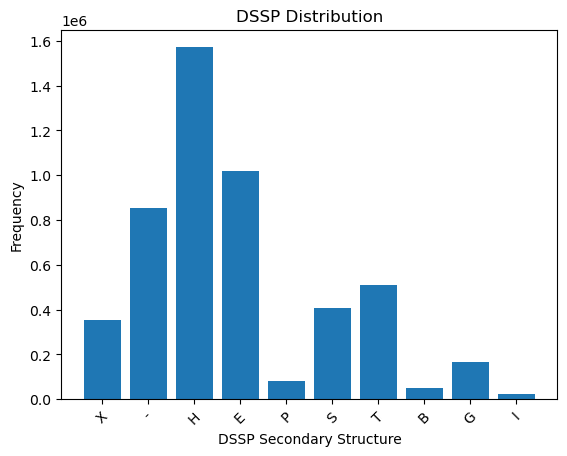

In [55]:
# plot the dssp distribution
import matplotlib.pyplot as plt

plt.bar(dssp_distribution.keys(), dssp_distribution.values())
plt.xlabel('DSSP Secondary Structure')
plt.ylabel('Frequency')
plt.title('DSSP Distribution')
plt.xticks(rotation=45)
plt.show()

In [57]:
# for all the times when the ['dssp'] entry is 'P', I want to get the corresponding ['seq'] entry for that position
aa_dist_at_kappa_helix = {}
for pdb_id in tqdm(data_pdb_dssp):
    try:
        dssp = data_pdb_dssp[pdb_id]['dssp']
        seq = data_pdb_dssp[pdb_id]['seq']
        for i, res in enumerate(dssp):
            if res == 'P':
                aa = seq[i]
                if aa not in aa_dist_at_kappa_helix:
                    aa_dist_at_kappa_helix[aa] = 0
                aa_dist_at_kappa_helix[aa] += 1
    except KeyError:
        continue


100%|██████████| 21668/21668 [00:00<00:00, 64998.95it/s]


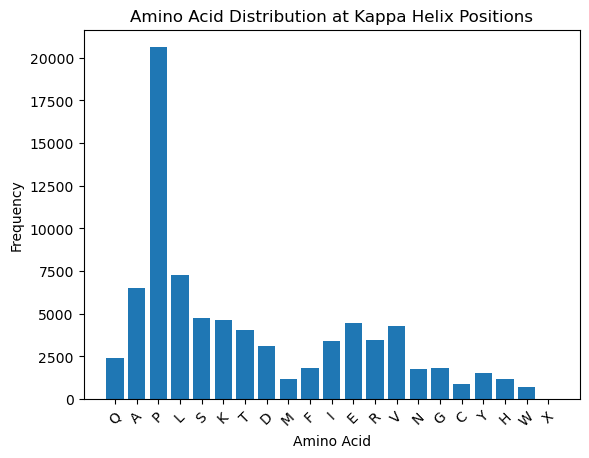

In [59]:
# plot the dssp distribution
import matplotlib.pyplot as plt

plt.bar(aa_dist_at_kappa_helix.keys(), aa_dist_at_kappa_helix.values())
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.title('Amino Acid Distribution at Kappa Helix Positions')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Demonstration of fallback 'X' assignment for failed DSSP processing

def create_fallback_dssp(sequence_length):
    """Create fallback DSSP array with 'X' values for failed processing."""
    return ['X'] * sequence_length

def process_with_fallback(pdb_file, sequence):
    """
    Process DSSP with fallback to 'X' values if processing fails.
    
    Args:
        pdb_file: Path to PDB file
        sequence: Expected protein sequence
        
    Returns:
        tuple: (dssp_array, status) where status indicates success/failure
    """
    try:
        # Try normal DSSP processing
        dssp, seq_dssp = compute_dssp(pdb_file)
        
        # Check if lengths match
        if len(sequence) == len(dssp):
            return dssp, 'success'
        else:
            print(f"Length mismatch: seq={len(sequence)}, dssp={len(dssp)}")
            return create_fallback_dssp(len(sequence)), 'length_mismatch'
            
    except Exception as e:
        print(f"DSSP processing failed: {e}")
        # Return fallback array with same length as sequence
        return create_fallback_dssp(len(sequence)), 'failed'

# Example usage with the dataset
print("🧪 Testing Fallback DSSP Assignment")
print("=" * 50)

# Test with a known good entry first
if 'data_pdb_dssp' in locals():
    sample_entry = list(data_pdb_dssp.keys())[0]
    sample_data = data_pdb_dssp[sample_entry]
    
    print(f"Sample entry: {sample_entry}")
    print(f"Sequence length: {len(sample_data['seq'])}")
    print(f"DSSP length: {len(sample_data['dssp'])}")
    print(f"First 10 DSSP values: {sample_data['dssp'][:10]}")
    
    # Simulate a failed case
    fake_sequence = "ACDEFGHIKLMNPQRSTVWY" * 5  # 100 residues
    fallback_dssp, status = process_with_fallback("nonexistent.pdb", fake_sequence)
    
    print(f"\nFallback test:")
    print(f"Fake sequence length: {len(fake_sequence)}")
    print(f"Fallback DSSP length: {len(fallback_dssp)}")
    print(f"Fallback DSSP values: {fallback_dssp[:10]} ...")
    print(f"Status: {status}")
    
    # Check if all values are 'X'
    all_x = all(x == 'X' for x in fallback_dssp)
    print(f"All values are 'X': {all_x}")
    
    # Show the difference between real DSSP and fallback
    print(f"\n🔍 Comparison:")
    print(f"Real DSSP:     {sample_data['dssp'][:20]}")
    print(f"Fallback DSSP: {['X'] * 20}")
    
else:
    print("❌ No DSSP dataset loaded. Run previous cells first.")

print("\n✅ This ensures every entry in your dataset will have a 'dssp' field")
print("   with the correct length, even if DSSP processing fails!")
print("\n📋 Summary of the updated script behavior:")
print("   - Missing PDB files: Creates array of 'X' values matching seq length")
print("   - DSSP failures: Creates array of 'X' values matching seq length") 
print("   - All entries get saved with proper 'dssp' field")
print("   - No missing data in the final dataset!")

# inspect dssp in pkl